In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

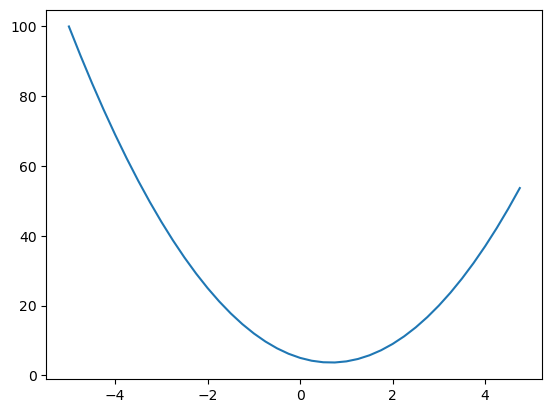

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.0001
x = 3.0

#This shows the amount of change in the slope of the function when we move from x to x + h.
print("Total slope change: ",(f(x + h) - f(x))) 

#This is the average rate of change of the function over the interval from x to x + h. 
# It gives us an approximation of the derivative of the function at x.
print("Avg rate of change: ",(f(x + h) - f(x)) / h)

Total slope change:  0.0014000300000063248
Avg rate of change:  14.000300000063248


In [8]:
#Getting more complex
a = 2
b = -3
c = 10
d = a*b + c
print(d)

4


In [9]:
h = 0.0001

#inputs
a = 2
b = -3
c = 10

d1 = a*b + c
c += h
d2 = a*b + c

print("d1: ", d1)
print("d2: ", d2)
print("Slope: ", (d2 - d1) /h)

d1:  4
d2:  4.0001
Slope:  0.9999999999976694


In [10]:
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data)
    
    def __mul__(self, other):
        return Value(self.data * other.data)
    

a = Value(2.0)
b = Value(-3.0)
print('a: ', a)
print('b: ', b)

#Internally calls a.__add__(b), where self is a and b is other.
print('a + b: ',a + b) 

print('a * b: ',a * b) 

#Now that we have both add and mul, we can do more complex things like (a * b) + c
c = Value(10.0)
print('(a * b) + c: ', (a * b) + c)

a:  Value(data = 2.0)
b:  Value(data = -3.0)
a + b:  Value(data = -1.0)
a * b:  Value(data = -6.0)
(a * b) + c:  Value(data = 4.0)


In [68]:
#Lets make it more complex

class Value:
    def __init__(self, data, _childen=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # This will hold the gradient of the value (change in slope with respect to the final output) during backpropagation.
        self._backward = lambda: None
        self._prev = set(_childen) #The set method prevents duplicate parents. 
        self._op = _op #Stores the operation used to create this value
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+") #Passing the children to the new value object in (self, other)
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo (v):
            if v not in visited: 
                visited.add (v)
                
                for child in v._prev: 
                    build_topo(child)
                    
                topo.append (v)
            
        build_topo(self) 
        self.grad = 1.0     
        for node in reversed(topo):
            node._backward()
        


a = Value(2.0 , label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = (a * b); e.label = 'e' #Just the syntax for creating a new value object from an expression and then labeling it.
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

print("d.prev: ", d._prev)
print("d._op: ", d._op)

d.prev:  {Value(data = -6.0), Value(data = 10.0)}
d._op:  +


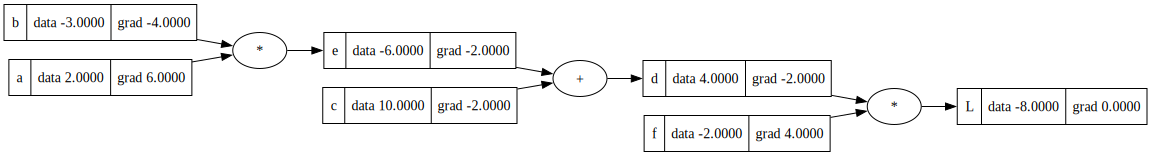

In [71]:
from graphviz import Digraph
# Simply a helper function to traverse the graph and collect all nodes and edges in a set, so we can visualize them later.
# Its purely for visualization purposes and has no effect on the actual backpropagation algorithm.

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

draw_dot(L)

In [70]:
# Manual backpropagation

# L = d * f
# dL/dd = f
d.grad = f.data

# So also, dl/df = d
f.grad = d.data

#Also if you think about it, d = e + c, so dd/de = 1 and dd/dc = 1
#Now we do our chain-rule aka backpropagation aka derivative multiplication

# dl/de = dl/dd * dd/de = f * 1.0
c.grad = d.grad * 1.0

# dl/dc = dl/dd * dd/dc = f * 1.0
e.grad = d.grad * 1.0

# You can notice that these plus nodes just copy the gradient to their inputs, they simply route back the gradient to their inputs.

# Now we have to go back to e = a * b, so de/da = b and de/db = a
# We also now know that dL/ de = -2.0, so we can calculate the gradients for a and b as well.

# dL/da = dL/de * de/da 
# dL/db = dL/de * de/db

a.grad = e.grad * b.data
b.grad = e.grad * a.data


In [14]:
# Testing values
a.data += a.grad * .01
b.data += b.grad * .01
c.data += c.grad * .01
f.data += f.grad * .01

# Re-running the forward pass with the new values to get the new output L.
e = a * b
d = e + c
L = d * f

print("L: ", L.data)

L:  -7.286496


Now here is the heart of the backpropagation algorithm
We need to calculate the gradients for c and e which are the parents of d, but d is not a leaf node

That is written as dd/dc and dd/de
These actual just end up being 1 because d = e + c, so dd/dc = 1 and dd/de = 1

But we need the derviative with respect to L not d.
So we can use the chain rule to calculate dL/dc and dL/de
All we need to do is multiply the derivatives together backwards from L to d and then to c and e.
BAM we are now backpropagating the gradients from L to d and then to c and e.

WANT:
dL / dc = (dL / dd) * (dd / dc)

KNOW:
dL / dd = -2
dd / dc = 1



In [15]:
L.grad = 1.0 #Manually setting the gradient of the final output to 1.0, since dL/dL = 1.0

In [16]:
def lol():
    h = 0.0001
    
    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = (a * b); e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data #Must say .data to reference the actual value of L, not the Value object itself.
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = (a * b); e.label = 'e' 
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 -  L1) / h)

lol()
    

6.000000000021544


Congrats You've done the most basic backpropogation. Now its time for neurons

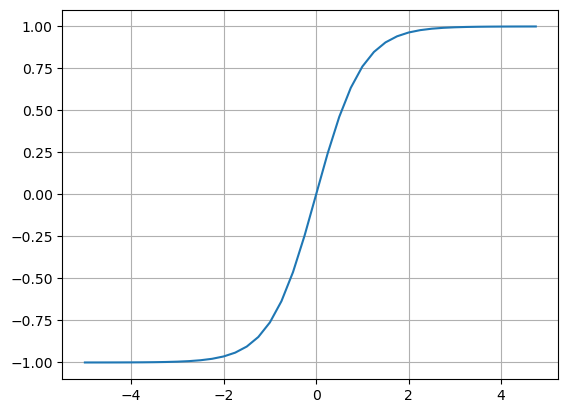

In [17]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))

plt.grid()

In [18]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# n is our activation function input
n = x1w1x2w2 + b; n.label = 'n'

#o is for output 
o = n.tanh(); o.label = 'o'


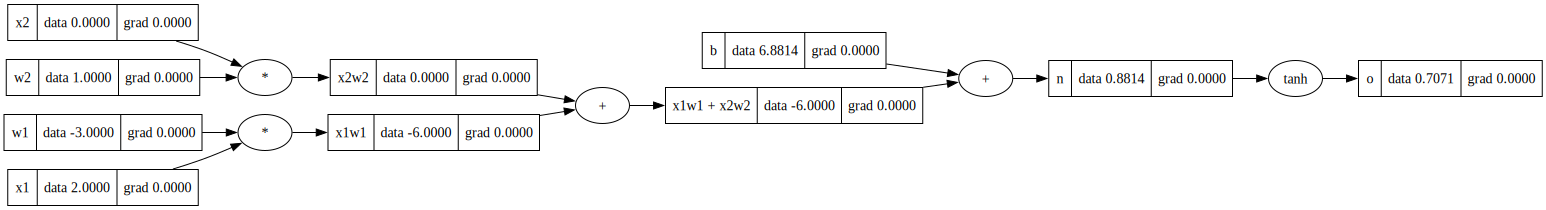

In [19]:
draw_dot(o)

In [20]:
o.backward() #Since we added the topo (bakcwards method) we no longer need to call backward on each non-leaf node, just the most child node will follow back through everything

In [21]:
#Automatic backpropagation

o.grad = 1.0
o._backward() #This will call the _backward function of o
n._backward()
b._backward() # Nothing happens here since b has no parents, but we call it for consistency

x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()


#These below dont do anything since x1, x2, w1, and w2 have no parents, but we call them for consistency. We don't call backprop on leaf nodes
x1._backward()
x2._backward()
w1._backward()
w2._backward()


In [22]:
#Lets do backpropagation on this neuron graph
o.grad = 1; # (since do/d0 = 1.0)

# o = tanh(n), so do/dn = 1 - tanh^2(n) OR JUST 1 - o^2
n.grad = o.grad * (1 - o.data ** 2)
print("n.grad: ", n.grad)

# n = x1w1x2w2 + b, so dn/dx1w1x2w2 = 1.0 and dn/db = 1.0
b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0

# x1w1x2w2 = x1w1 + x2w2, so dx1w1x2w2/dx1w1 = 1.0 and dx1w1x2w2/dx2w2 = 1.0
x1w1.grad = x1w1x2w2.grad * 1.0
x2w2.grad = x1w1x2w2.grad * 1.0

# x1w1 = x1 * w1, so dx1w1/dx1 = w1 and dx1w1/dw1 = x1
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

# x2w2 = x2 * w2, so dx2w2/dx2 = w2 and dx2w2/dw2 = x2
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad



n.grad:  0.4999999999999999


In [67]:
#Fomrating into a topological sort, aka purely left to right, will allow the single call of the child node to backprop

topo = []
visited = set()

def build_topo (v):
    if v not in visited: 
        visited.add (v)
        
        for child in v._prev: 
            build_topo(child)
            
        topo.append (v)
    
build_topo (o)
topo

[Value(data = -1),
 Value(data = 2),
 Value(data = 6.881373587019543),
 Value(data = 2.0),
 Value(data = -3.0),
 Value(data = -6.0),
 Value(data = 1.0),
 Value(data = 0.0),
 Value(data = 0.0),
 Value(data = -6.0),
 Value(data = 0.8813735870195432),
 Value(data = 1.7627471740390863),
 Value(data = 5.828427124746192),
 Value(data = 4.828427124746192),
 Value(data = 1),
 Value(data = 6.828427124746192),
 Value(data = 0.1464466094067262),
 Value(data = 0.7071067811865477)]

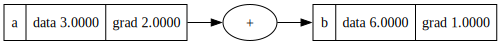

In [24]:
#Wait we have a bug
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

#We fixed this by making the add/mult += rather than +, the issue came from identicals being treated as individuals when they need to be combined into a single node

## Next Section 

In [122]:
#Just bring value class down

class Value:
    def __init__(self, data, _childen=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # This will hold the gradient of the value (change in slope with respect to the final output) during backpropagation.
        self._backward = lambda: None
        self._prev = set(_childen) #The set method prevents duplicate parents. 
        self._op = _op #Stores the operation used to create this value
        self.label = label
    
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) #saying if other isnt a value object than were turning it into one
        out = Value(self.data + other.data, (self, other), "+") #Passing the children to the new value object in (self, other)
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) #saying if other isnt a value object than were turning it into one
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): 
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now, not another value object"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        return out
        
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1

    def __truediv__(self, other): 
        return self * other**-1 #We need to create a pow overload function for this to work with a value object
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self , ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo (v):
            if v not in visited: 
                visited.add (v)
                
                for child in v._prev: 
                    build_topo(child)
                    
                topo.append (v)
                
        build_topo(self) 
        self.grad = 1.0     
        for node in reversed(topo):
            node._backward()

In [82]:
#Test to see if our + and * value obejct check works
a = Value(3.0)
a += 1

#Multiply?
2 * a # this fails because the 2.__mul__(a) won't work since 2 or self isnt being checked for is its a value object

#To solve this we must add the __rmul__ method which acts as a fallback, in which we will swap the order so it does work aka a.__mul__(2)


Value(data = 8.0)

In [37]:
#Testing out the exp function
a = Value(2.0, label='a')
a.exp()

Value(data = 7.38905609893065)

In [45]:
#We now want division
a = Value(2.0, label='a')
b = Value(3.0, label='b')
# a / b this fails

#Division can be reshuffled to the following
# a * (1/b)
# a * b^-1

a - b

Value(data = -1.0)

In [73]:
#Bringing this code back down

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# n is our activation function input
n = x1w1x2w2 + b; n.label = 'n'

#o is for output 
o = n.tanh(); o.label = 'o'

o.backward()



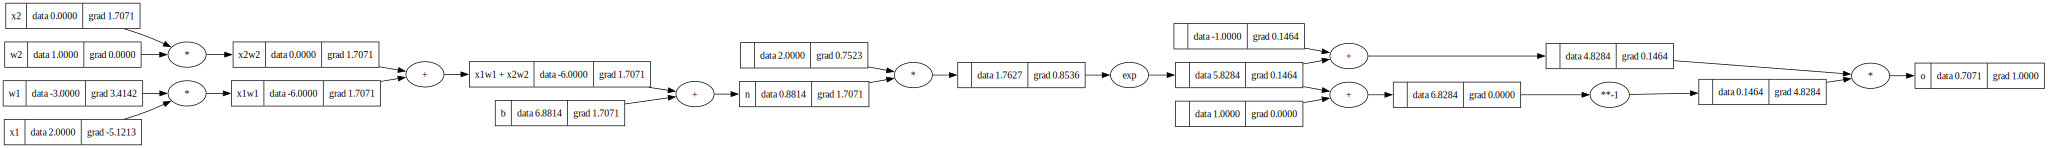

In [80]:
draw_dot(o)

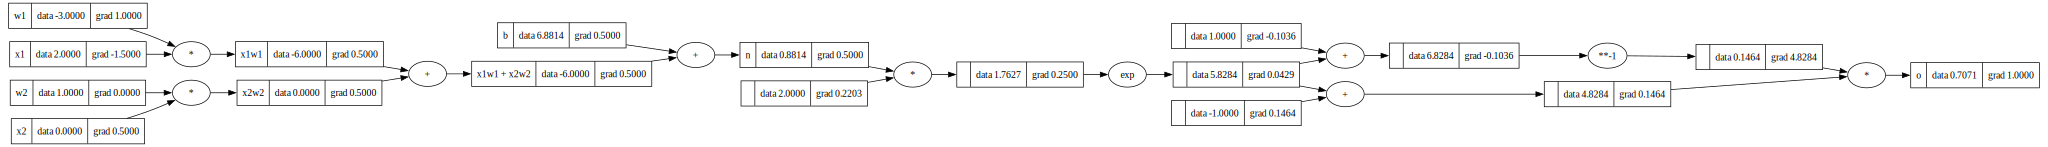

In [84]:
# I want to break up the tanh into a new expression

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias b
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

# n is our activation function input
n = x1w1x2w2 + b; n.label = 'n'

#o is for output, but lets break up rather than just using the bailout tanh
#o = ((2*n).exp() - 1) / ((2*n).exp() + 1); o.label = 'o'

e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)


## Introducing the Pytorch api 

In [239]:
import torch  

In [240]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
# We required gradients because most will be leaf nodes, and we want to be able to call backward on them to get their gradients.

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [241]:
torch.Tensor([[1,2,3], [4,5,6]])
torch.Tensor([[1,2,3], [4,5,6]]).shape
torch.Tensor([[1,2,3], [4,5,6]]).dtype #Want to make a double since python floats are 64 bit and the default tensor is 32 bit, so we want to make sure we have the same precision as our value class
 


torch.float32

In [242]:
print(o)
print()
print(o.item()) # Or o.data.item()
print()
print(x2.grad.item()) 

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

0.7071066904050358

0.5000001283844369


In [299]:
# Lets build a sinbgle neuron in pytorch
from numpy import random

# nin: number of inputs into the neuron

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # random weights for each input
        self.b = Value(random.uniform(-1,1)) # random bias 
    
    def __call__(self, x): 
        # w * x + b, or dot product of w and x plus b
        
        #Zip pairs up the weights and inputs together so we can do a sum of w_i * x_i for each input
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x  ):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        #params = []
        #for neuron in self.neurons:
        #    ps = neuron.parameters()
        #    params.extend(ps)
        #return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [244]:
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])

n.parameters()

[Value(data = 0.792115622964193),
 Value(data = 0.005975013062599288),
 Value(data = 0.5888383620487156),
 Value(data = -0.07030971892458027),
 Value(data = 0.17477399002379634),
 Value(data = 0.17779228441196282),
 Value(data = -0.5974447564614536),
 Value(data = -0.7069792966970898),
 Value(data = 0.8216642195473978),
 Value(data = -0.0788575982394768),
 Value(data = 0.354811616905115),
 Value(data = -0.30683347313502773),
 Value(data = -0.19777315790037608),
 Value(data = -0.5435636057644464),
 Value(data = 0.09796524186818578),
 Value(data = 0.48585642598042367),
 Value(data = 0.36574984198876015),
 Value(data = -0.9690459116161476),
 Value(data = -0.25523086179036225),
 Value(data = -0.4009818119443649),
 Value(data = 0.5402077625638497),
 Value(data = -0.30127153253532923),
 Value(data = -0.23664130028128771),
 Value(data = -0.07556842478927872),
 Value(data = 0.8096578472529747),
 Value(data = 0.6891621951426146),
 Value(data = -0.2672589019762941),
 Value(data = 0.3698267719271

In [245]:
len(n.parameters())

41

In [302]:
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))
print()
# We can now feed those numbers into the neuron to get an output

n = Layer(2, 3) #Layer with 3 inputs and 3 outputs
print(n(x))
print()

x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 3, 1]) #MLP with 3 inputs, 3 layers of 4 neurons each, and then a final layer of 1 output
print(n(x))

Value(data = 0.9998520959567851)

[Value(data = 0.955163840759054), Value(data = 0.827132638058816), Value(data = -0.6035853694572564)]

Value(data = 0.9564174034816445)


In [248]:
xs = [
    [2.0, 3.0, -1],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, -1.0] #desired targets
ypred = [n(x) for x in xs]
print(ypred) #show current results

[Value(data = 0.9781122191546011), Value(data = 0.9833442314817932), Value(data = 0.6392379100955357), Value(data = 0.9674143720602815)]


In [ ]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]) #MSE loss for each example
loss #goal is to minimize this loss

Value(data = 10.49195365278617)

In [290]:
for p in n.parameters(): #go through all parameters in the MLP
    p.data += -0.01 * p.grad #tiny update to each parameter, in the direction that reduces the loss (negative gradient)

In [291]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]) #MSE loss for each example
loss #see improvment

Value(data = 3.9953180877883008)

In [251]:
loss.backward() #This will backpropagate through the entire graph and calculate the gradients for all the parameters in the MLP

In [ ]:
ypred #We have now trained, and its pretty good

[Value(data = -0.9988277786681625),
 Value(data = -0.9984970314357348),
 Value(data = -0.9988362562284371),
 Value(data = -0.9985908162898264)]

In [295]:
n.parameters

<bound method MLP.parameters of <__main__.MLP object at 0x128a337a0>>

Lets add Loops


In [306]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 3, 1]) #MLP with 3 inputs, 3 layers of 4 neurons each, and then a final layer of 1 output
print(n(x))

Value(data = -0.6740314949974661)


In [307]:
xs = [
    [2.0, 3.0, -1],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, -1.0] #desired targets
ypred = [n(x) for x in xs]
print(ypred) #show current results

[Value(data = -0.6740314949974661), Value(data = -0.805209335335525), Value(data = -0.7177635993069589), Value(data = -0.5012174290412416)]


In [ ]:
for k in range(10000):
    
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]) #MSE loss for each example
    loss #goal is to minimize this loss
    
    # backward pass
    for p in n.parameters(): # We need to zero out the gradients before calling backward, since they will accumulate by default
        p.grad = 0.0
        
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.00019538014887055146
1 0.0001953121774069237
2 0.0001952442528560588
3 0.0001951763751696092
4 0.00019510854429929332
5 0.00019504076019689795
6 0.00019497302281427405
7 0.00019490533210334075
8 0.00019483768801608587
9 0.00019477009050455432
10 0.00019470253952085623
11 0.00019463503501718503
12 0.00019456757694577434
13 0.00019450016525893808
14 0.00019443279990905856
15 0.0001943654808485669
16 0.00019429820802997896
17 0.000194230981405858
18 0.0001941638009288435
19 0.000194096666551633
20 0.00019402957822699227
21 0.0001939625359077465
22 0.0001938955395467944
23 0.00019382858909708896
24 0.00019376168451165588
25 0.00019369482574357633
26 0.00019362801274599534
27 0.00019356124547213115
28 0.00019349452387526267
29 0.00019342784790872037
30 0.000193361217525915
31 0.0001932946326803095
32 0.00019322809332543016
33 0.00019316159941487406
34 0.00019309515090229712
35 0.0001930287477414138
36 0.00019296238988600402
37 0.00019289607728991562
38 0.00019282980990705466
39 0.000192

In [341]:
ypred

[Value(data = 0.9950300415259656),
 Value(data = -0.9982279883647485),
 Value(data = -0.9975210794090985),
 Value(data = -0.9969516366911692)]

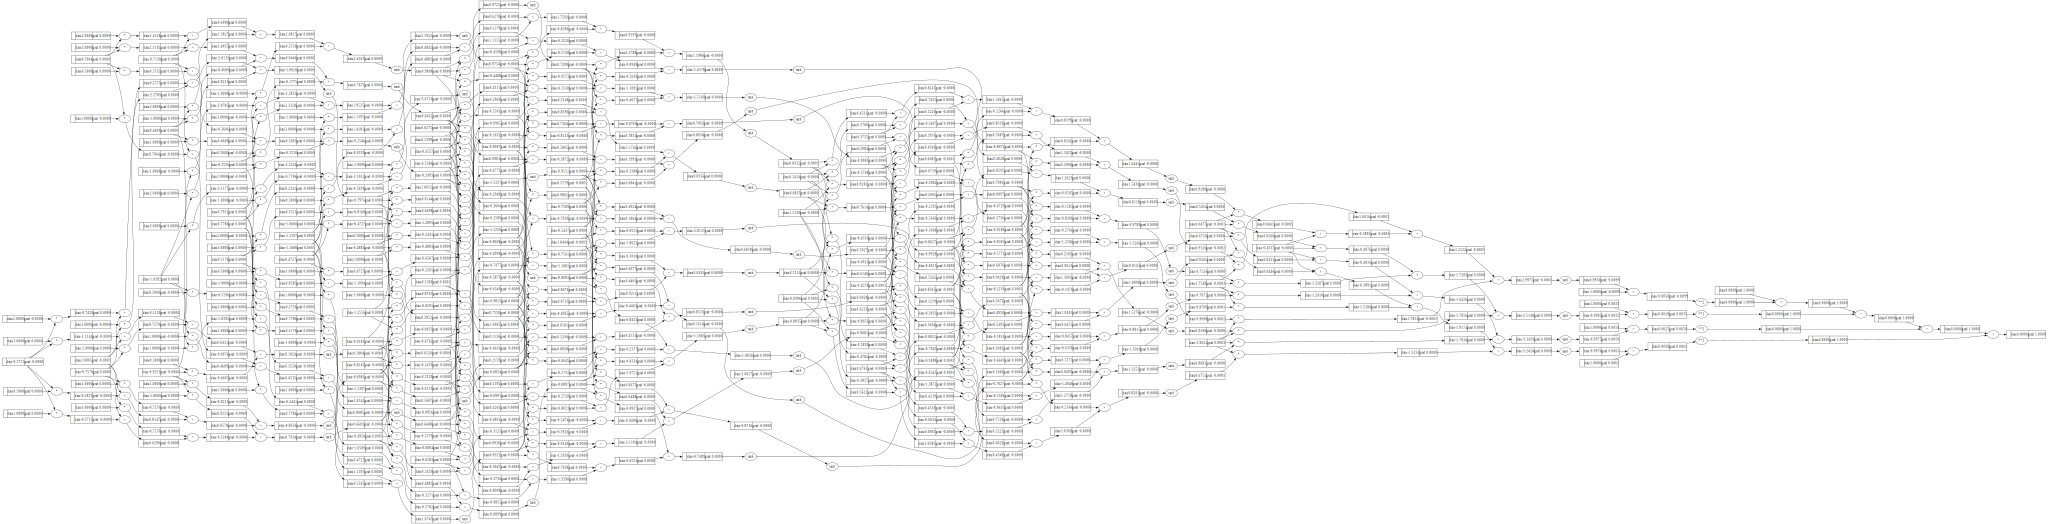

In [343]:
# 1. New Forward Pass (Creates the graph)
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

# 2. New Backward Pass (Fills in the .grad values)
loss.backward()

# 3. Now draw it!
draw_dot(loss)